# Assignment 3 by: Linh Thuy Do (s3927777)

In [154]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, GridSearchCV
from random import sample
from sklearn.metrics import average_precision_score
from sklearn.metrics.pairwise import cosine_similarity

# Task 1: kNN-based Collaborative Filtering

In [5]:
# Load data with appropriate separators
ratings = pd.read_csv(r"C:\Users\linhd\Downloads\ml-1m\ratings.dat", sep='::', engine='python', names=['UserID', 'MovieID', 'Rating', 'Timestamp'], encoding='ISO-8859-1')
users = pd.read_csv(r"C:\Users\linhd\Downloads\ml-1m\users.dat", sep='::', engine='python', names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], encoding='ISO-8859-1')
movies = pd.read_csv(r"C:\Users\linhd\Downloads\ml-1m\movies.dat", sep='::', engine='python', names=['MovieID', 'Title', 'Genres'], encoding='ISO-8859-1')

In [8]:
ratings

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [9]:
users

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [10]:
movies

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [20]:
# Merge ratings with movies to get more information
merged_df = pd.merge(ratings, movies, on='MovieID')

In [22]:
merged_df

,UserID,MovieID,Rating,Timestamp,Title,Genres
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance
3,1,3408,4,978300275,Erin Brockovich (2000),Drama
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy
...,...,...,...,...,...,...
1000204,6040,1091,1,956716541,Weekend at Bernie's (1989),Comedy
1000205,6040,1094,5,956704887,"Crying Game, The (1992)",Drama|Romance|War
1000206,6040,562,5,956704746,Welcome to the Dollhouse (1995),Comedy|Drama
1000207,6040,1096,4,956715648,Sophie's Choice (1982),Drama


In [24]:
# Constructing the user-movie interaction matrix
user_movie_matrix = merged_df.pivot_table(index='UserID', columns='MovieID', values='Rating')

# Replace missing ratings (NaN) with 0
user_movie_matrix.fillna(0, inplace=True)

In [28]:
# Select a user at random from the matrix
selected_user = np.random.choice(user_movie_matrix.index)

# Extract the selected user's rated movies (test set)
user_test_ratings = user_movie_matrix.loc[selected_user]
user_test_ratings = user_test_ratings[user_test_ratings > 0]

In [30]:
# Compute Cosine Similarity between users
def calculate_cosine_similarity(user_matrix):
    similarity_matrix = cosine_similarity(user_matrix)
    return pd.DataFrame(similarity_matrix, index=user_matrix.index, columns=user_matrix.index)

# Compute Pearson Correlation between users
def calculate_pearson_correlation(user_matrix):
    pearson_correlation_matrix = user_matrix.T.corr(method='pearson')
    return pearson_correlation_matrix

# Predict movie ratings based on k-NN approach
def generate_predictions(sim_matrix, user_matrix, selected_user, k_neighbors):    
    # Retrieve similarity scores for other users
    similarity_scores = sim_matrix[selected_user].sort_values(ascending=False)[1:]  # Exclude the user themselves
    
    # Select top k similar users
    top_k_similar_users = similarity_scores.index[:k_neighbors]
    
    # Calculate the predicted ratings by averaging top k users' ratings
    avg_predicted_ratings = user_matrix.loc[top_k_similar_users].mean(axis=0)
    
    # Return predicted ratings for all movies (both rated and unrated)
    return avg_predicted_ratings

# Function to compute RMSE between actual and predicted ratings
def compute_rmse(actual_ratings, predicted_ratings):
    # Find the movies rated in both actual and predicted sets
    common_movies = actual_ratings.index.intersection(predicted_ratings.index)
    if len(common_movies) == 0:
        print("No overlapping movies between actual and predicted ratings.")
        return None
    actual_values = actual_ratings.loc[common_movies]
    predicted_values = predicted_ratings.loc[common_movies]
    
    if len(predicted_values) == 0:
        print("No valid predicted ratings.")
        return None
    
    # Calculate and return RMSE
    return sqrt(mean_squared_error(actual_values, predicted_values))

In [32]:
# Compute similarity matrices using both methods
cosine_sim_matrix = calculate_cosine_similarity(user_movie_matrix)
pearson_sim_matrix = calculate_pearson_correlation(user_movie_matrix)

In [33]:
# Range of k-values to evaluate
k_neighbors_list = [3, 5, 10, 15, 20]
rmse_cosine_results = {}
rmse_pearson_results = {}

for k_neighbors in k_neighbors_list:
    # Predictions using Cosine Similarity
    cosine_predictions = generate_predictions(cosine_sim_matrix, user_movie_matrix, selected_user, k_neighbors)
    rmse_cosine = compute_rmse(user_test_ratings, cosine_predictions)
    rmse_cosine_results[k_neighbors] = rmse_cosine

    # Predictions using Pearson Correlation
    pearson_predictions = generate_predictions(pearson_sim_matrix, user_movie_matrix, selected_user, k_neighbors)
    rmse_pearson = compute_rmse(user_test_ratings, pearson_predictions)
    rmse_pearson_results[k_neighbors] = rmse_pearson

# Display RMSE results for both similarity methods
print("RMSE using Cosine Similarity:")
for k_neighbors, rmse_value in rmse_cosine_results.items():
    print(f"k = {k_neighbors}: RMSE = {rmse_value}")

print("\nRMSE using Pearson Correlation:")
for k_neighbors, rmse_value in rmse_pearson_results.items():
    print(f"k = {k_neighbors}: RMSE = {rmse_value}")

RMSE using Cosine Similarity:
k = 3: RMSE = 1.7252214028607715
k = 5: RMSE = 1.7206103568210902
k = 10: RMSE = 1.7208282889353022
k = 15: RMSE = 1.705595366889684
k = 20: RMSE = 1.7162459031269384

RMSE using Pearson Correlation:
k = 3: RMSE = 1.7252214028607715
k = 5: RMSE = 1.7206103568210902
k = 10: RMSE = 1.7208282889353022
k = 15: RMSE = 1.705595366889684
k = 20: RMSE = 1.7595365156767846


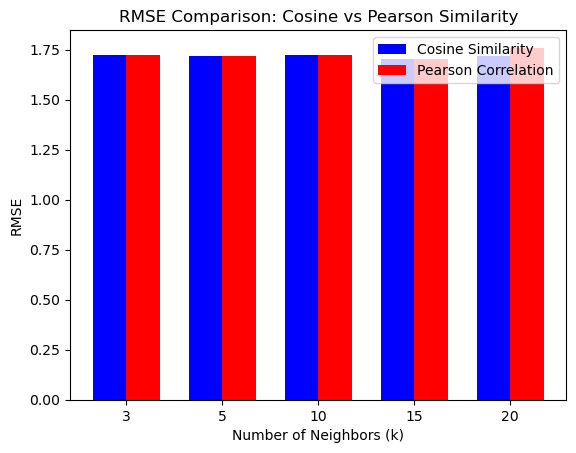

In [36]:
# Plotting RMSE results for comparison
bar_width = 0.35
x_positions = np.arange(len(k_neighbors_list))

# Initialize the plot
fig, ax = plt.subplots()

# Bar plot for Cosine Similarity
cosine_bar = ax.bar(x_positions, list(rmse_cosine_results.values()), bar_width, label='Cosine Similarity', color='blue')

# Bar plot for Pearson Correlation
pearson_bar = ax.bar(x_positions + bar_width, list(rmse_pearson_results.values()), bar_width, label='Pearson Correlation', color='red')

# Adding labels, title, and legend
ax.set_xlabel('Number of Neighbors (k)')
ax.set_ylabel('RMSE')
ax.set_title('RMSE Comparison: Cosine vs Pearson Similarity')
ax.set_xticks(x_positions + bar_width / 2)
ax.set_xticklabels(k_neighbors_list)
ax.legend()

# Display the plot
plt.show()

# Task 2: Matrix Factorization-based Recommendation

In [76]:
# Load the ratings dataset
ratings = pd.read_csv(r"C:\Users\linhd\Downloads\ml-1m\ratings.dat", sep='::', engine='python', names=['UserID', 'MovieID', 'Rating', 'Timestamp'], encoding='ISO-8859-1')

In [77]:
# Perform SVD using scikit-learn
latent_factors = 50  # Number of components (latent features)
svd_model = TruncatedSVD(n_components=latent_factors)
decomposed_user_movie_matrix = svd_model.fit_transform(user_movie_matrix)

# Approximate the original matrix from the decomposed one
approx_user_movie_matrix = np.dot(decomposed_user_movie_matrix, svd_model.components_)

In [78]:
# Select 5 random movies
all_movie_ids = user_movie_matrix.columns
selected_movies = np.random.choice(all_movie_ids, size=5, replace=False)
print("Chosen movies:", selected_movies)

# Estimate ratings for these chosen movies
estimated_ratings = approx_user_movie_matrix[:, [user_movie_matrix.columns.get_loc(movie_id) for movie_id in selected_movies]]

Chosen movies: [ 714 3168  440  749 1200]


In [79]:
# Create a DataFrame to display the predictions and clip ratings between 1 and 5
predicted_ratings_df = pd.DataFrame(estimated_ratings, columns=selected_movies).clip(lower=1, upper=5)

# Output predicted ratings for all users on the selected movies
print("Clipped Predicted Ratings for Users on Selected Movies:")
print(predicted_ratings_df)

Clipped Predicted Ratings for Users on Selected Movies:
          714       3168      440   749       1200
0     1.000000  1.000000  1.000000   1.0  1.000000
1     1.000000  1.000000  1.000000   1.0  1.000000
2     1.000000  1.000000  1.000000   1.0  1.000000
3     1.000000  1.000000  1.000000   1.0  1.659457
4     1.000000  1.000000  1.000000   1.0  1.000000
...        ...       ...       ...   ...       ...
6035  1.426174  2.113850  1.931458   1.0  5.000000
6036  1.000000  1.000000  1.000000   1.0  3.535079
6037  1.000000  1.000000  1.000000   1.0  1.000000
6038  1.000000  1.000000  1.000000   1.0  1.000000
6039  1.000000  1.177837  1.000000   1.0  3.423501

[6040 rows x 5 columns]


In [80]:
# Get actual ratings for these movies
true_ratings = user_movie_matrix[selected_movies]

# Define a function to compute RMSE for each selected movie
def calculate_movie_rmse(true_ratings, predicted_ratings):
    rmse_per_movie = {}
    for movie_id in true_ratings.columns:
        actual = true_ratings[movie_id].values
        predicted = predicted_ratings[movie_id].values
        
        # Compute RMSE for the current movie
        rmse_value = sqrt(mean_squared_error(actual, predicted))
        rmse_per_movie[movie_id] = rmse_value
    
    return rmse_per_movie

# Compute RMSE for the selected movies
original_rmse_values = calculate_movie_rmse(true_ratings, predicted_ratings_df)

In [81]:
# Display RMSE for each movie
for movie_id, rmse in original_rmse_values.items():
    print(f"RMSE for movie {movie_id}: {rmse}")

RMSE for movie 714: 1.0983925262118517
RMSE for movie 3168: 1.1847296412475583
RMSE for movie 440: 1.288295905328692
RMSE for movie 749: 1.0010755805036875
RMSE for movie 1200: 1.2856631080562098


In [82]:
# Prepare the utility matrix for SVD by replacing missing values with 0
matrix_for_svd = user_movie_matrix.fillna(0).to_numpy()

# Parameters for early stopping
min_delta = 0.0001  # Minimum RMSE improvement to consider
max_iterations = 100  # Maximum number of iterations
patience = 5  # Number of iterations with no improvement before stopping

In [84]:
# Function to run SVD with early stopping based on RMSE
def svd_with_early_stopping(matrix, n_factors, max_iterations=100, patience=5, min_delta=0.0001):
    svd_model = TruncatedSVD(n_components=n_factors)
    best_rmse = float('inf')
    best_matrix = None
    no_improvement = 0
    
    for iteration in range(max_iterations):
        decomposed_matrix = svd_model.fit_transform(matrix)
        approximated_matrix = np.dot(decomposed_matrix, svd_model.components_)

        # Calculate RMSE
        current_rmse = sqrt(mean_squared_error(matrix, approximated_matrix))

        # Check if early stopping criteria are met
        if best_rmse - current_rmse < min_delta:
            no_improvement += 1
        else:
            no_improvement = 0
            best_rmse = current_rmse
            best_matrix = approximated_matrix
        
        if no_improvement >= patience:
            print(f"Stopping early at iteration {iteration}, RMSE: {best_rmse}")
            break
    
    return best_matrix, best_rmse

In [90]:
# Set up grid for testing different numbers of latent factors
hyperparameters = {
    'n_components': [20, 50, 100]
}

# Grid search for the best number of latent factors
optimal_rmse = float('inf')
optimal_factors = None
best_approximation = None

for n_factors in hyperparameters['n_components']:
    print(f"Testing with n_components = {n_factors}")
    approx_matrix, rmse_value = svd_with_early_stopping(matrix_for_svd, n_factors, max_iterations=max_iterations, patience=patience, min_delta=min_delta)

    if rmse_value < optimal_rmse:
        optimal_rmse = rmse_value
        optimal_factors = n_factors
        best_approximation = approx_matrix

print(f"Optimal number of latent factors: {optimal_factors}, with RMSE: {optimal_rmse}")

Testing with n_components = 20
Stopping early at iteration 5, RMSE: 0.5967602724884771
Testing with n_components = 50
Stopping early at iteration 5, RMSE: 0.5633540886893351
Testing with n_components = 100
Stopping early at iteration 5, RMSE: 0.5289254383153348
Optimal number of latent factors: 100, with RMSE: 0.5289254383153348


In [93]:
# Predict ratings for the selected movies using the best approximated matrix
estimated_ratings = best_approximation[:, [user_movie_matrix.columns.get_loc(mid) for mid in selected_movies]]

# Clip predicted ratings to the range [1, 5]
predicted_ratings_df = pd.DataFrame(estimated_ratings, columns=selected_movies).clip(1, 5)

# Calculate RMSE for each selected movie
improved_rmse_values = calculate_movie_rmse(true_ratings, predicted_ratings_df)

# Output RMSE for each movie
for movie_id, rmse_value in improved_rmse_values.items():
    print(f"RMSE for movie {movie_id}: {rmse_value}")

RMSE for movie 714: 1.092780968480603
RMSE for movie 3168: 1.161919916181891
RMSE for movie 440: 1.2455436534299074
RMSE for movie 749: 1.0010755805036875
RMSE for movie 1200: 1.1830372048733493


<Figure size 1000x600 with 0 Axes>

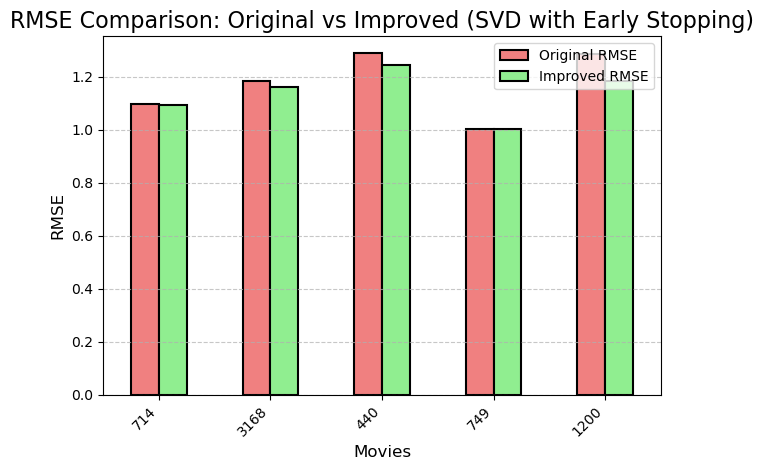

In [94]:
# Convert RMSE values to DataFrame for plotting
rmse_comparison_df = pd.DataFrame({
    'Original RMSE': original_rmse_values,
    'Improved RMSE': improved_rmse_values
})

# Plot the comparison of RMSE
plt.figure(figsize=(10, 6))
rmse_comparison_df.plot(kind='bar', color=['lightcoral', 'lightgreen'], edgecolor='black', linewidth=1.5)

# Add labels and title
plt.title('RMSE Comparison: Original vs Improved (SVD with Early Stopping)', fontsize=16)
plt.xlabel('Movies', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate movie labels for better visibility

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the legend
plt.legend(['Original RMSE', 'Improved RMSE'], loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

# Task 3: Ranking-based Evaluation and Comparison

In [100]:
# Load the ratings dataset
ratings = pd.read_csv(r"C:\Users\linhd\Downloads\ml-1m\ratings.dat", sep='::', engine='python', names=['UserID', 'MovieID', 'Rating', 'Timestamp'], encoding='ISO-8859-1')

In [134]:
# Filter users who have rated more than 100 movies
user_rating_counts = (user_movie_matrix > 0).sum(axis=1)
active_users = user_rating_counts[user_rating_counts > 100].index.tolist()

# Randomly select 10 users from this filtered list
sampled_users = sample(active_users, 10)
print("Sampled Users:", sampled_users)

Sampled Users: [2398, 2533, 5053, 23, 1172, 6010, 1034, 1301, 5677, 3532]


In [156]:
# Predict ratings using k-NN based on a similarity matrix
def knn_predict(similarity_matrix, rating_matrix, user_id, k_neighbors):
    user_similarity_scores = similarity_matrix[user_id].sort_values(ascending=False)[1:]  # Exclude self
    top_k_neighbors = user_similarity_scores.index[:k_neighbors]
    predicted_ratings = rating_matrix.loc[top_k_neighbors].mean(axis=0)
    return predicted_ratings

# Calculate Average Precision (AP)
def calculate_average_precision(actual_ratings, predicted_ratings):
    # Ensure actual ratings and predictions are non-empty and have the same index
    if actual_ratings.empty or predicted_ratings.empty:
        return None
    
    # Binary relevance for actual ratings (1 if rating >= 4, else 0)
    binary_actuals = (actual_ratings >= 4).astype(int)
    
    # Convert to arrays to ensure compatibility with average_precision_score
    binary_actuals = binary_actuals.to_numpy()
    predicted_ratings = predicted_ratings.to_numpy()
    
    # Calculate and return AP score
    return average_precision_score(binary_actuals, predicted_ratings)

# Discounted Cumulative Gain at K 
def discounted_cumulative_gain(ratings, k):
    ratings = np.asfarray(ratings)[:k]
    return np.sum(ratings / np.log2(np.arange(2, ratings.size + 2)))

# Normalized Discounted Cumulative Gain at K (NDCG@K)
def normalized_dcg(actual, predicted, k=10):
    sorted_actual = actual.sort_values(ascending=False)
    sorted_predicted = predicted.loc[sorted_actual.index].sort_values(ascending=False)
    ideal_dcg = discounted_cumulative_gain(sorted_actual.values, k)
    dcg_value = discounted_cumulative_gain(sorted_predicted.values, k)
    return dcg_value / ideal_dcg if ideal_dcg > 0 else 0

In [170]:
# Set k value for optimal KNNCF
cosine_sim_matrix = calculate_cosine_similarity(user_movie_matrix)
optimal_k = 10  # Assuming 10 as the optimal number of neighbors

# KNNCF Collaborative Filtering Results
for user in sampled_users:
    actual_user_ratings = user_movie_matrix.loc[user]
    rated_movies = actual_user_ratings[actual_user_ratings > 0]

    # Predict ratings using the k-NN model
    predicted_user_ratings = knn_predict(cosine_sim_matrix, user_movie_matrix, user, optimal_k)

    # Filter out movies already rated by the user
    unrated_predictions = predicted_user_ratings.drop(rated_movies.index, errors='ignore')

    # Get top 20 movie recommendations
    top_20_recommendations = unrated_predictions.nlargest(20)

    # Filter predictions to only include movies the user has rated for evaluation
    predicted_filtered = predicted_user_ratings[rated_movies.index]

    # Check if actual and predicted ratings have enough items for AP and NDCG calculations
    if not rated_movies.empty and not predicted_filtered.empty:
        ap_score = calculate_average_precision(rated_movies, predicted_filtered)
        ndcg_score = normalized_dcg(rated_movies, predicted_filtered, k=10)

        # Store results
        knn_cf_results[user] = {'AP': ap_score, 'NDCG': ndcg_score, 'Top_20_Movies': top_20_recommendations}
    else:
        print(f"Skipping user {user} due to insufficient data for AP/NDCG calculation")

In [171]:
# Display k-NN Collaborative Filtering Results
for user, metrics in knn_cf_results.items():
    print(f"User {user} - AP: {metrics['AP']}, NDCG: {metrics['NDCG']}")
    print("Top 20 recommended movies (MovieID - Predicted Rating):")
    print(metrics['Top_20_Movies'])
    print("\n")

User 2398 - AP: 0.8016063166217787, NDCG: 0.8631817529453379
Top 20 recommended movies (MovieID - Predicted Rating):
MovieID
318     4.6
1196    4.4
3147    4.1
593     4.0
608     4.0
1221    3.9
1208    3.6
1276    3.6
1393    3.6
1293    3.5
1617    3.5
1193    3.4
1242    3.4
1272    3.4
1302    3.4
919     3.1
1287    3.1
1674    3.1
2858    3.1
2336    3.0
dtype: float64


User 2533 - AP: 0.8421706004316121, NDCG: 0.7881185686436255
Top 20 recommended movies (MovieID - Predicted Rating):
MovieID
377     3.8
17      3.5
2396    3.4
1680    2.9
1721    2.6
1923    2.5
39      2.3
266     2.3
838     2.3
1183    2.3
2581    2.3
222     2.1
509     2.1
1597    2.0
2291    2.0
105     1.9
265     1.9
468     1.9
527     1.9
1188    1.9
dtype: float64


User 5053 - AP: 0.7782478827554455, NDCG: 0.9091135153625367
Top 20 recommended movies (MovieID - Predicted Rating):
MovieID
1274    3.7
1356    3.5
2393    3.2
3052    3.1
110     3.0
2396    2.9
3070    2.9
329     2.6
2502    2.5
122

In [198]:
# SVD with Early Stopping
matrix_for_svd = user_movie_matrix.fillna(0).values
min_delta = 0.0001  # Minimum RMSE improvement to consider
max_iterations = 100  # Maximum number of iterations
patience = 5  # Number of iterations with no improvement before stopping
latent_factors = 50  # Number of latent factors for SVD

# Run SVD with early stopping to get the improved approximation matrix
best_approx_matrix, final_rmse = svd_with_early_stopping(
    matrix_for_svd,
    latent_factors,         
    max_iterations,
    patience,
    min_delta
)
print("Final RMSE after early stopping:", final_rmse)

Stopping early at iteration 5, RMSE: 0.5633699680036962
Final RMSE after early stopping: 0.5633699680036962


In [199]:
# Convert the approximation matrix to a DataFrame for easier indexing
predicted_ratings_df = pd.DataFrame(best_approx_matrix, index=user_movie_matrix.index, columns=user_movie_matrix.columns)

# Initialize storage for evaluation results using IMFR
imfr_evaluation_results = {}

for user in sampled_users:
    # Retrieve actual ratings for movies rated by the user
    user_actual_ratings = user_movie_matrix.loc[user]
    actual_rated_movies = user_actual_ratings[user_actual_ratings > 0]

    # Retrieve predicted ratings from the IMFR model
    user_predicted_ratings = predicted_ratings_df.loc[user]

    # Exclude movies the user has already rated
    unseen_movies = user_predicted_ratings.drop(actual_rated_movies.index, errors='ignore')

    # Select the top 20 movie recommendations for the user
    top_20_recommendations = unseen_movies.nlargest(20)

    # Filter predictions to only include movies rated by the user
    filtered_predicted_ratings = user_predicted_ratings[actual_rated_movies.index]

    # Calculate AP and NDCG for the actual rated movies
    if not actual_rated_movies.empty and not filtered_predicted_ratings.empty:
        ap_score = calculate_average_precision(actual_rated_movies, filtered_predicted_ratings)
        ndcg_score = normalized_dcg(actual_rated_movies, filtered_predicted_ratings, k=10)

        # Store results, including the top 20 recommended movies
        imfr_evaluation_results[user] = {
            'AP': ap_score,
            'NDCG': ndcg_score,
            'Top_20_Movies': top_20_recommendations
        }
    else:
        print(f"Skipping user {user} due to insufficient data for AP/NDCG calculation")

In [200]:
# Display IMFR evaluation results
for user, metrics in imfr_evaluation_results.items():
    print(f"User {user} - AP: {metrics['AP']}, NDCG: {metrics['NDCG']}")
    print("Top 20 recommended movies (MovieID - Predicted Rating):")
    print(metrics['Top_20_Movies'])
    print("\n")

User 2398 - AP: 0.7988744926007324, NDCG: 0.5854177228142328
Top 20 recommended movies (MovieID - Predicted Rating):
MovieID
1221    2.638191
318     2.580630
1193    2.323163
1302    2.163715
1682    2.068490
3418    1.975404
1250    1.898366
590     1.846404
3105    1.824269
3255    1.794351
3448    1.726745
3100    1.662610
356     1.626741
1213    1.594965
34      1.587606
1293    1.585899
1960    1.564095
3252    1.560098
2336    1.547012
1242    1.543656
Name: 2398, dtype: float64


User 2533 - AP: 0.8666979683447463, NDCG: 0.9080813864048606
Top 20 recommended movies (MovieID - Predicted Rating):
MovieID
1721    3.293822
1777    2.875607
2355    2.254287
2321    2.103256
39      2.099389
1193    1.987932
377     1.971749
1835    1.954462
318     1.933412
1441    1.880392
2496    1.865811
3247    1.813175
586     1.811435
317     1.805736
1923    1.805051
2125    1.793701
3450    1.746375
141     1.737314
367     1.729631
105     1.728546
Name: 2533, dtype: float64


User 5053 - 

In [201]:
# Display evaluation results for KNNCF
for user, metrics in knn_cf_results.items():
    print(f"User {user} - AP: {metrics['AP']}, NDCG: {metrics['NDCG']}")
    print("Top 20 recommended movies (MovieID - Predicted Rating):")
    print(metrics['Top_20_Movies'])
    print("\n")

User 2398 - AP: 0.8016063166217787, NDCG: 0.8631817529453379
Top 20 recommended movies (MovieID - Predicted Rating):
MovieID
318     4.6
1196    4.4
3147    4.1
593     4.0
608     4.0
1221    3.9
1208    3.6
1276    3.6
1393    3.6
1293    3.5
1617    3.5
1193    3.4
1242    3.4
1272    3.4
1302    3.4
919     3.1
1287    3.1
1674    3.1
2858    3.1
2336    3.0
dtype: float64


User 2533 - AP: 0.8421706004316121, NDCG: 0.7881185686436255
Top 20 recommended movies (MovieID - Predicted Rating):
MovieID
377     3.8
17      3.5
2396    3.4
1680    2.9
1721    2.6
1923    2.5
39      2.3
266     2.3
838     2.3
1183    2.3
2581    2.3
222     2.1
509     2.1
1597    2.0
2291    2.0
105     1.9
265     1.9
468     1.9
527     1.9
1188    1.9
dtype: float64


User 5053 - AP: 0.7782478827554455, NDCG: 0.9091135153625367
Top 20 recommended movies (MovieID - Predicted Rating):
MovieID
1274    3.7
1356    3.5
2393    3.2
3052    3.1
110     3.0
2396    2.9
3070    2.9
329     2.6
2502    2.5
122

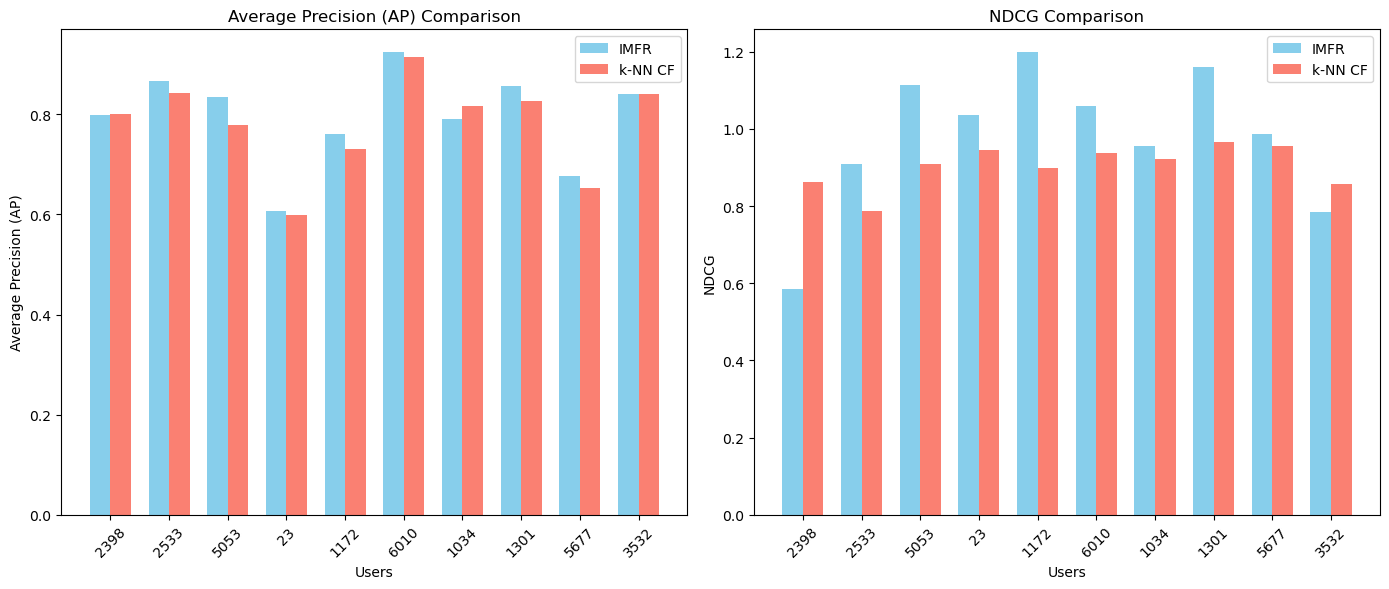

In [202]:
# Extract users and metrics from results
users = list(imfr_evaluation_results.keys())
imfr_ap_scores = [metrics['AP'] for metrics in imfr_evaluation_results.values()]
imfr_ndcg_scores = [metrics['NDCG'] for metrics in imfr_evaluation_results.values()]
knn_ap_scores = [knn_cf_results[user]['AP'] for user in users]
knn_ndcg_scores = [knn_cf_results[user]['NDCG'] for user in users]

# Set up positions and bar width
x = np.arange(len(users))
width = 0.35

# Plot AP scores comparison
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot Average Precision (AP) scores
ax[0].bar(x - width/2, imfr_ap_scores, width, label='IMFR', color='skyblue')
ax[0].bar(x + width/2, knn_ap_scores, width, label='k-NN CF', color='salmon')
ax[0].set_xlabel('Users')
ax[0].set_ylabel('Average Precision (AP)')
ax[0].set_title('Average Precision (AP) Comparison')
ax[0].set_xticks(x)
ax[0].set_xticklabels(users, rotation=45)
ax[0].legend()

# Plot NDCG scores comparison
ax[1].bar(x - width/2, imfr_ndcg_scores, width, label='IMFR', color='skyblue')
ax[1].bar(x + width/2, knn_ndcg_scores, width, label='k-NN CF', color='salmon')
ax[1].set_xlabel('Users')
ax[1].set_ylabel('NDCG')
ax[1].set_title('NDCG Comparison')
ax[1].set_xticks(x)
ax[1].set_xticklabels(users, rotation=45)
ax[1].legend()

plt.tight_layout()
plt.show()